In [78]:
from collections import Counter
from functions import color_displayer
from functions import progressBar
import matplotlib
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import pandas as pd
import os
import plotly.io as pio
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

"""
Author: David Dooley
Email: ddooley2@vols.utk.edu
Description:
This code takes an input directory within the working directory that contains all tsv files from centrifuge.py,
cleans data, tabulates all hits for given reference sequences, and plots a bar graph with customizable legend
and x labels.
"""

###Code assumes that tsv files for different barcodes are all in the same subdirectory of the cwd

read_bool = input('\nWould you like relative abundances to be calculated base-wise? (Default is read-wise) (y/n)\n> ')
if read_bool == 'y':
    read_bool = True
else:
    read_bool = False

tsv_dir = os.getcwd() + '/' + input("\nPlease input sub directory with tsv files: ")




In [79]:
#Use collections.Counter on [seqID].tolist() to find out how many times each ID had a hit, after filtering out unclassified and empty hits
master_df = pd.DataFrame() ###Initialize dataframe
l = len(os.listdir(tsv_dir))
progressBar.printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Initialize progress bar
for it, tsv in enumerate(sorted(os.listdir(tsv_dir))): ###Iterate through all tsv files generated from centrifuge.py
    tsv_path = tsv_dir + '/' + tsv
    df = pd.read_table(tsv_path)
    df = df[~df.seqID.str.contains("unclassified")] ###Removes all reads with unclassified sequence hit
    df = df[~df.seqID.str.contains("no rank")] ###Removes all reads with no rank sequence hit
    df = df[~(df['numMatches'] > 1)] ###Removes all reads with non-unique (repeat) hits
    seqid_list = df['seqID'].tolist() ###
    hit_list = df['hitLength'].tolist()
    seqid_count = Counter(seqid_list)
    """ Map num bases or num reads """
    if read_bool: ###Base-based mapping
        base_count = {}
        for i, item in enumerate(seqid_list):
            if item not in base_count.keys():
                base_count[item] = hit_list[i]
            else:
                base_count[item] += hit_list[i]
        if it == 0:
            master_df['organism_ID'] = [*seqid_count]
            master_df[tsv.split('_')[0]+'_mappedbases'] = master_df['organism_ID'].map(base_count)
        else:
            master_df[tsv.split('_')[0]+'_mappedbases'] = master_df['organism_ID'].map(base_count)

    else: ###Read-based mapping
        if it == 0:
            master_df['organism_ID'] = [*seqid_count]
            master_df[tsv.split('_')[0]] = master_df['organism_ID'].map(seqid_count)
        else:
            master_df[tsv.split('_')[0]] = master_df['organism_ID'].map(seqid_count)

    progressBar.printProgressBar(it+1, l, prefix = 'Progress:', suffix = 'Complete', length = 50) ###Update progress bar
master_df.fillna(0, inplace=True) ###Replaces NaNs with 0s in case an organism had no bases mapped to it

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [80]:
norm_df = master_df.drop('organism_ID',axis=1).transpose().apply(lambda x: x*100/sum(x), axis =1) ###Transposes and normalizes all columns except for organism names
barcode_names = list(norm_df.index)
read_count = master_df.sum(axis=0, skipna=True, numeric_only=True).tolist() ###Sums the total number of mapped reads per barcode

""" Option to change bar names """
loop_escape = False
my_bool = input('\nWould you like to rename barcodes (y/n)? ')
while not loop_escape:
    if my_bool == "y":
        my_bool = True
        loop_escape = True
    elif my_bool == "n":
        loop_escape = True
        my_bool = False
        continue
    else:
        my_bool = input('\nPlease enter "y" or "n" ')

if my_bool:
    barcode_names = [str(input('\nEnter series name for %s: ' % name)) for name in barcode_names]

if read_bool:
    xlabs = [name + '\n (' + str("{:.3e}".format(read_count[i])) + ' bp)' for i, name in enumerate(barcode_names)] ###Add bases to barcode labels in scientific notation
else:
    xlabs = [name + '\n (' + str(read_count[i]) + ' reads)' for i, name in enumerate(barcode_names)] ###Add reads to barcode labels

""" Option to change label names """
legend_names = master_df['organism_ID'].tolist()
loop_escape = False
my_bool = input('\nWould you like to rename legends (y/n)? ')
while not loop_escape:
    if my_bool == "y":
        my_bool = True
        loop_escape = True
    elif my_bool == "n":
        loop_escape = True
        my_bool = False
        continue
    else:
        my_bool = input('\nPlease enter "y" or "n" ')

if my_bool:
    legend_names = [str(input('\nEnter legend name for %s: ' % name)) for name in legend_names]


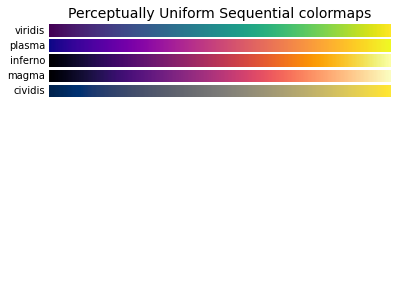

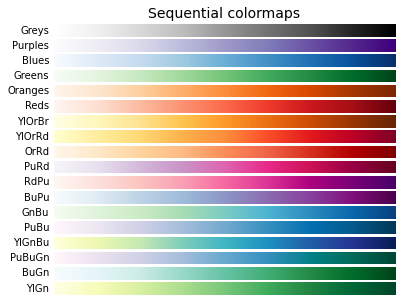

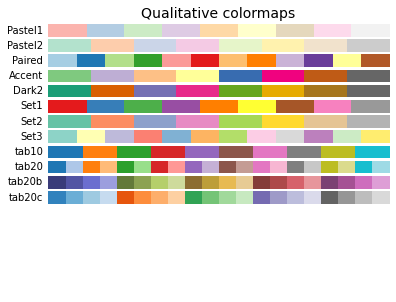

In [94]:
""" Begin plotting everything """
###Show color palettes and prompt user to select one
color_displayer.show_colors()
plt.show()
color = input("\nPlease enter the name of your desired color palette: ").strip()
cmap = matplotlib.cm.get_cmap(color, len(norm_df.columns))
colors = []
for i in range(len(norm_df.columns)):
    rgb = cmap(i)[:3]
    colors.append(str("rgb("+str(rgb[0])+", " + str(rgb[1])+", " + str(rgb[2]) +")"))    
 

In [117]:
###Actually plot figures
#fig, ax1 = plt.subplots()
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout=layout)
for i, col in enumerate(norm_df.columns):
    fig.add_trace(go.Bar(x=barcode_names,y=norm_df[col],name=legend_names[i],marker_color=colors[i], marker=dict(line=dict(width=0))))
fig.update_layout(barmode="stack", autosize=True, bargroupgap=0.15, margin=dict(t=15,b=15), legend=dict(font=dict(size=10),valign="middle",y = 0.5))
fig.update_yaxes(title_text="Relative Abundance",zeroline=True, zerolinewidth=1, zerolinecolor="Gray",showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.show()
print(fig.layout.width)

None


In [37]:
name = input('\nSave figure as: ')
fig.savefig(name, bbox_inches = 'tight', dpi=500)
master_df.to_csv(name.split(".")[0] +'_master.csv', index=False, header=True, sep=',')
norm_df.to_csv(name.split(".")[0] +'_norm.csv', index=False, header=True, sep=',')

NameError: name 'a' is not defined